[View in Colaboratory](https://colab.research.google.com/github/ajoshiusc/brainsync/blob/master/deep_rigid.ipynb)

/usr/local/lib/python3.6/dist-packages/skimage/viewer/__init__.py:6: UserWarning: Viewer requires Qt
  warn('Viewer requires Qt')


------------------------------
Loading and preprocessing train data...
------------------------------
Creating and compiling model...
Fitting Model
Train on 204 samples, validate on 52 samples
Epoch 1/50
204/204 [==============================] - 3s 14ms/step - loss: 520.9473 - mean_squared_error: 520.9473 - val_loss: 540.3860 - val_mean_squared_error: 540.3860
Epoch 2/50
204/204 [==============================] - 1s 5ms/step - loss: 516.3177 - mean_squared_error: 516.3177 - val_loss: 533.0954 - val_mean_squared_error: 533.0954
Epoch 3/50
204/204 [==============================] - 1s 5ms/step - loss: 515.9148 - mean_squared_error: 515.9148 - val_loss: 537.2321 - val_mean_squared_error: 537.2321
Epoch 4/50
204/204 [==============================] - 1s 5ms/step - loss: 516.1366 - mean_squared_error: 516.1366 - val_loss: 531.4005 - val_mean_squared_error: 531.4005
Epoch 5/50
204/204 [==============================] - 1s 5ms/step - loss: 515.9597 - mean_squared_error: 515.9597 - val_loss: 

Epoch 12/50
204/204 [==============================] - 1s 5ms/step - loss: 184.5730 - mean_squared_error: 184.5730 - val_loss: 240.2164 - val_mean_squared_error: 240.2164
Epoch 13/50
204/204 [==============================] - 1s 5ms/step - loss: 199.8496 - mean_squared_error: 199.8496 - val_loss: 149.4695 - val_mean_squared_error: 149.4695
Epoch 14/50
204/204 [==============================] - 1s 5ms/step - loss: 164.9664 - mean_squared_error: 164.9664 - val_loss: 177.0768 - val_mean_squared_error: 177.0768
Epoch 15/50
204/204 [==============================] - 1s 5ms/step - loss: 153.2393 - mean_squared_error: 153.2393 - val_loss: 126.0219 - val_mean_squared_error: 126.0219
Epoch 16/50
204/204 [==============================] - 1s 5ms/step - loss: 125.1572 - mean_squared_error: 125.1572 - val_loss: 146.1907 - val_mean_squared_error: 146.1907
Epoch 17/50
204/204 [==============================] - 1s 5ms/step - loss: 115.6739 - mean_squared_error: 115.6739 - val_loss: 125.8671 - val_mea

204/204 [==============================] - 1s 5ms/step - loss: 86.3909 - mean_squared_error: 86.3909 - val_loss: 103.3778 - val_mean_squared_error: 103.3778
Epoch 25/50
204/204 [==============================] - 1s 5ms/step - loss: 80.2191 - mean_squared_error: 80.2191 - val_loss: 116.6598 - val_mean_squared_error: 116.6598
Epoch 26/50
204/204 [==============================] - 1s 5ms/step - loss: 84.9973 - mean_squared_error: 84.9973 - val_loss: 107.4754 - val_mean_squared_error: 107.4754
Epoch 27/50
204/204 [==============================] - 1s 5ms/step - loss: 86.2947 - mean_squared_error: 86.2947 - val_loss: 111.9038 - val_mean_squared_error: 111.9038
Epoch 28/50
204/204 [==============================] - 1s 5ms/step - loss: 82.0788 - mean_squared_error: 82.0788 - val_loss: 120.5037 - val_mean_squared_error: 120.5037
Epoch 29/50
204/204 [==============================] - 1s 5ms/step - loss: 83.4845 - mean_squared_error: 83.4845 - val_loss: 119.6047 - val_mean_squared_error: 119.604

204/204 [==============================] - 1s 5ms/step - loss: 47.6006 - mean_squared_error: 47.6006 - val_loss: 96.8067 - val_mean_squared_error: 96.8067
Epoch 37/50
204/204 [==============================] - 1s 5ms/step - loss: 48.8717 - mean_squared_error: 48.8717 - val_loss: 101.1779 - val_mean_squared_error: 101.1779
Epoch 38/50
204/204 [==============================] - 1s 5ms/step - loss: 47.5942 - mean_squared_error: 47.5942 - val_loss: 84.9455 - val_mean_squared_error: 84.9455
Epoch 39/50
204/204 [==============================] - 1s 5ms/step - loss: 42.3157 - mean_squared_error: 42.3157 - val_loss: 93.2387 - val_mean_squared_error: 93.2387
Epoch 40/50
204/204 [==============================] - 1s 5ms/step - loss: 34.7375 - mean_squared_error: 34.7375 - val_loss: 80.1962 - val_mean_squared_error: 80.1962
Epoch 41/50
204/204 [==============================] - 1s 5ms/step - loss: 29.1872 - mean_squared_error: 29.1872 - val_loss: 89.8661 - val_mean_squared_error: 89.8661
Epoch 42

204/204 [==============================] - 1s 5ms/step - loss: 9.2845 - mean_squared_error: 9.2845 - val_loss: 75.7358 - val_mean_squared_error: 75.7358
Epoch 49/50
204/204 [==============================] - 1s 5ms/step - loss: 8.4400 - mean_squared_error: 8.4400 - val_loss: 85.8522 - val_mean_squared_error: 85.8522
Epoch 50/50
204/204 [==============================] - 1s 5ms/step - loss: 6.6003 - mean_squared_error: 6.6003 - val_loss: 79.9920 - val_mean_squared_error: 79.9920
dict_keys(['val_loss', 'val_mean_squared_error', 'loss', 'mean_squared_error'])


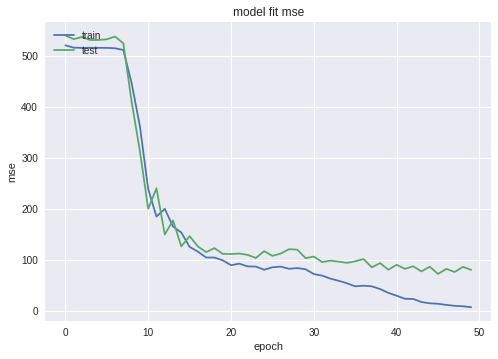

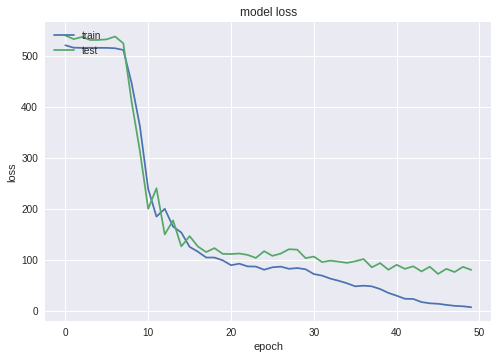

Test data...


In [4]:
#AUM
#Shree Ganeshaya Namaha
from skimage import transform as tf
from skimage.transform import resize, rotate
from skimage.color import rgb2gray
from skimage.io import imread
from keras.layers import Input,Conv2D,concatenate,MaxPooling2D,Flatten,Dense
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras import backend as K
import numpy as np
from numpy.random import uniform
import matplotlib.pyplot as plt
from skimage.viewer import ImageViewer


K.set_image_data_format('channels_last')  # TF dimension ordering in this code

from keras import losses
img_rows = 128
img_cols = 128

from google.colab import files
uploaded = files.upload()






def get_rr_net():
    inputs = Input((img_rows, img_cols, 2))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
    flat1 = Flatten()(conv5)
    d1= Dense(64,activation='relu')(flat1)
    out_theta = Dense(3)(d1)
#    conv_tx = Conv2D(1, (1, 1), activation=final_activation)(conv5)
#    conv_ty = Conv2D(1, (1, 1), activation=final_activation)(conv5)
#    conv_theta = Conv2D(1, (1, 1), activation='tanh')(conv5)

#    out_img = rotate(inputs,conv_theta)

    model = Model(inputs=[inputs], outputs=out_theta)

    model.compile(optimizer='adam', loss=losses.mean_squared_error, metrics=['mse'])

    return model


def gen_train_data(img, N=1024):
    imgs_train = np.zeros((N, img.shape[0], img.shape[1], 2))
    noise = uniform(low=-1,high=1,size=imgs_train.shape)
    out_train = np.zeros((N, 3))
    rot = uniform(low=-60, high=60, size=(N,1))
    tx = uniform(low=-25, high=25, size=(N,1))
    ty = uniform(low=-25, high=25, size=(N,1))
    out_train[:,0]=rot.squeeze()
    out_train[:,1]=tx.squeeze()
    out_train[:,2]=ty.squeeze()

    in_rot = uniform(low=-90, high=90, size=(N,1))
 
    for j in range(N):
      
#        img2 = tf.warp(img,aff)
        img2 = rotate(img, in_rot[j])
        img2 -= np.mean(img2)
        img2 /= np.std(img2)
        imgs_train[j, :, :, 0] = img2 + noise[j,:,:,0]
        aff = tf.AffineTransform(rotation = (np.pi/180.0)*rot[j], translation=(tx[j],ty[j]))
        img3 = 10-1*np.tanh(tf.warp(img2, aff)) +  noise[j,:,:,1]#
        img3 -= np.mean(img3)
        img3 /= np.std(img3)
        imgs_train[j, :, :, 1] = img3
        
        if 0:
            viewer = ImageViewer(img3)
            viewer.show()

    return imgs_train, out_train


def train_and_predict():
    print('-'*30)
    print('Loading and preprocessing train data...')
    print('-'*30)
    img = resize(rgb2gray(imread('sample_brain.png')).astype('float32'),(img_rows,img_cols),mode='constant')
    mean = np.mean(img)  # mean for data centering
    std = np.std(img)  # std for data normalization

    img -= mean
    img /= std

    imgs_train, out_train = gen_train_data(img, 256)

    print('Creating and compiling model...')
    rrmodel = get_rr_net()
    model_checkpoint = ModelCheckpoint('weights.h5', monitor='val_loss', save_best_only=True)

    print('Fitting Model')
    history = rrmodel.fit(imgs_train, out_train, batch_size=32, epochs=50, verbose=1,
                shuffle=True, validation_split=0.2,
                callbacks=[model_checkpoint])
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['mean_squared_error'])
    plt.plot(history.history['val_mean_squared_error'])
    plt.title('model fit mse')
    plt.ylabel('mse')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    print('Test data...')
    

if __name__ == '__main__':
    train_and_predict()
